In [12]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import re

In [13]:
df_raw = pd.read_csv("cfb_dataset.csv", encoding="latin-1")
df_raw.head()

,Date,Team,Time,Opponent,Rank,Site,TV,Result,Attendance,Current Wins,...,PRCP,SNOW,SNWD,TMAX,TMIN,Opponent_Rank,Conference,Year,Month,Day
0,9/2/2000,Arkansas,8:00 PM,Southwest Missouri State*,NR,"War Memorial StadiumLittle Rock, AR",Not on TV,W 380,53946,0,...,0.00,0.0,0.0,105,65,NR,SEC,2000,9,2
1,9/16/2000,Arkansas,6:00 PM,Boise State*,NR,"War Memorial StadiumLittle Rock, AR",Not on TV,W 3831,54286,1,...,0.00,0.0,0.0,79,44,NR,SEC,2000,9,16
2,9/23/2000,Arkansas,8:00 PM,Alabama,NR,"Razorback StadiumFayetteville, AR",ESPN2,W 2821,51482,2,...,2.12,0.0,0.0,85,63,NR,SEC,2000,9,23
3,9/30/2000,Arkansas,11:30 AM,No. 25 Georgia,NR,"Razorback StadiumFayetteville, AR",JPS,L 738,51162,3,...,0.00,0.0,0.0,77,45,25,SEC,2000,9,30
4,10/7/2000,Arkansas,6:00 PM,LouisianaMonroe*,NR,"Razorback StadiumFayetteville, AR",Not on TV,W 526,50947,3,...,0.00,0.0,0.0,50,28,NR,SEC,2000,10,7


In [14]:
"""
Explanations for possibly confusing columns:
* Rank - Ranking based on AP Poll (ranked only for top-25 teams, "NR" otherwise)
* Fill rate - same as Attendance / Stadium Capacity attributes
* TV - which channel the game is broadcasted on
* PRCP, SNOW, SNWD - precipitation, snow, and snow depth

Note:
* Each game is only recorded ONCE from the HOME TEAM's perspective, 
  which we'll have to account for in feature engineering
* This dataset only contains 63 CFB schools and doesn't contain, say Texas.
  However, this should not influence our modeling since the actual name
  of a school should be more or less irrelevant
* This dataset also does not include playoff games (but includes rivalry games
  and conference championship games)
"""
df_raw.columns

Index(['Date', 'Team', 'Time', 'Opponent', 'Rank', 'Site', 'TV', 'Result',
       'Attendance', 'Current Wins', 'Current Losses', 'Stadium Capacity',
       'Fill Rate', 'New Coach', 'Tailgating', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'Opponent_Rank', 'Conference', 'Year', 'Month', 'Day'],
      dtype='object')

In [15]:
"""
Ideas for new features
* Win percentage for the season
* Number of games in the season so far
* Opponent wins and losses
* Opponent conference
* Home game vs. bowl game
* Rivalry game and championship games
* Binary win/loss attribute
* Temperature differential for road team
* Number of points scored by offense in season
* Number of points allowed by defense in season
"""

'\nIdeas for new features\n* Win percentage for the season\n* Number of games in the season so far\n* Opponent wins and losses\n* Opponent conference\n* Home game vs. bowl game\n* Rivalry game and championship games\n* Binary win/loss attribute\n* Temperature differential for road team\n* Number of points scored by offense in season\n* Number of points allowed by defense in season\n'

In [16]:
# Irrelevant features (not even used for feature engineering)
to_drop = [
    "TV",
    "Stadium Capacity",  # choosing to keep "Fill Rate" and "Attedance" instead
    "Day",  # redundant since we already have "Date", also should not have an impact
]
df = df_raw.drop(columns=to_drop)

In [17]:
# Convert to datetime object for ease of processing
convert_datetime = lambda s: datetime.strptime(s, "%m/%d/%Y")
df["Date"] = df["Date"].apply(convert_datetime)

In [18]:
# Drop invalid rows (4355 resulted in Not Contest, 5449 was a spring game)
df = df.drop(index=[4355, 5449])

"""
Extract win/loss for each game, convert to binary variable (1 for win, 0 for loss)
There are more wins than losses (at home) for the 63 teams in the dataset
Note: we cannot generate records from the away team's perspective since we don't have all the relevant information
"""
extract_result = lambda s: 1 if re.match("^(W|L)", s).group(1) == "W" else 0
df["Result"] = df["Result"].apply(extract_result)

In [19]:
"""
As you can see, the vast majority of values for SNOW and SNWD are zeroes (used to indicate
snowfall and snowfall depth. Therefore, we will be dropping both attributes.
"""
print((df["SNOW"] > 0).value_counts(), end="\n\n")
print((df["SNWD"] > 0).value_counts())
df = df.drop(columns=["SNOW", "SNWD"])

SNOW
False    6633
True       37
Name: count, dtype: int64

SNWD
False    6635
True       35
Name: count, dtype: int64


FCS games count: 91


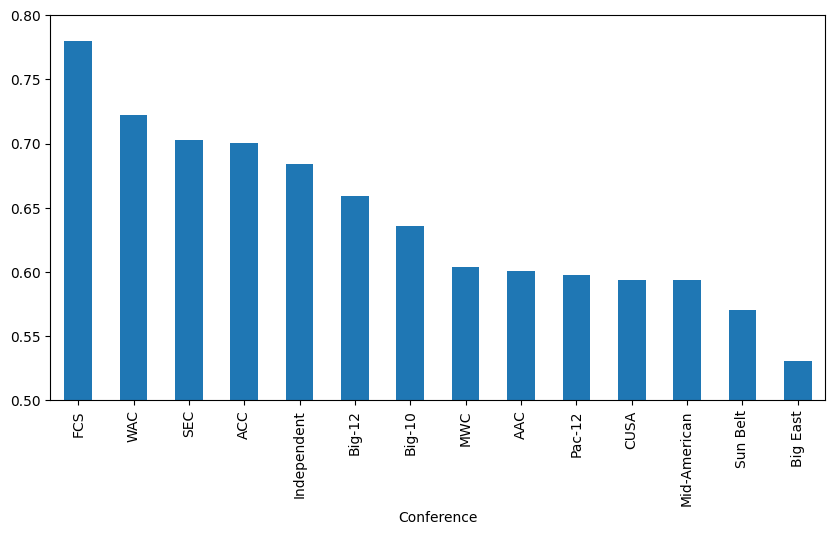

In [77]:
"""
A school's conference has a huge impact in college football, some conferences
(e.g. SEC) have been historical football strongholds, whereas others (e.g. AAC,
Pac-12) often struggle with out-of-conference games.

After calculating the win rates grouped by conference, we can see that the rates
vary widely. Interestingly FCS (the second tier of D1 football) and WAC (the Western
Athletic Conference, inactive from 2013 to 2020) have the highest win rates. This
might be because that there is only a small sample size of FCS school games, and
WAC schools play few strong out of conference opponents by design of the conference.
"""
print("FCS games count:", len(df[df["Conference"] == "FCS"]))
stats = df.groupby("Conference")["Result"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
stats.plot(kind="bar")
plt.ylim([0.5, 0.8])
plt.show()

In [21]:
"""
Here we process game data to clean and standardize opponent names and determine their conferences:
1. Clean opponent names by removing special characters, rankings (e.g. "No. 2"), and other symbols.
2. Match each opponent to their conference based on the year and team data from the dataset.
3. Add two new columns:
   - "Clean_Opponent": A cleaned version of the opponent name.
   - "Opponent_Conference": The corresponding conference for the opponent, or "N/A" if not found.
A limitation of this approach is that we can only impute the "Opponent_Conference" for opponents
that are also one of the 63 schools included in the dataset. However, this is sufficient for our
application.
"""
def clean_opponent_name(name):
    name = name.replace("\xa0", " ")
    return re.sub(r"No\.\s*\d+\s*", "", name).rstrip('*')

def calc_opponent_conference(row, dataset):
    opponent = row["Clean_Opponent"]
    year = row["Year"]
    opponent_games = dataset[(dataset["Team"] == opponent) & (dataset["Year"] == year)]
    
    if not opponent_games.empty:
        conference = opponent_games["Conference"].dropna().iloc[0]
        return conference
    else:
        return "N/A"

df["Opponent"] = df["Opponent"].apply(clean_opponent_name)
df["Opponent_Conference"] = df.apply(calc_opponent_conference, axis=1, args=(df,))

In [24]:
"""
The actually team names should be generally irrelevant in win prediction, this will also
allow us to run the model on schools that were not in the original dataset.
"""
to_drop = [
    "Team", "Opponent",
    "Site", 
    "Date", "Year", "Month",
]
df = df.drop(columns=to_drop)

In [34]:
"""
Convert rank to a numerical value, "NR" or no ranking is represented with 26,
which is one higher than the lowest possible ranking (25).
"""
convert_rank = lambda v: int(v) if v != "NR" else 26
df["Rank"] = df["Rank"].apply(convert_rank)
df["Opponent_Rank"] = df["Opponent_Rank"].apply(convert_rank)

In [57]:
"""
Normalize the start times of the games. CFB games start between 10 AM and 9 PM.
0 represents a game starting at 10 AM and vice versa.
"""
convert_start_time = lambda t: datetime.strptime(t, "%I:%M %p")
times = df["Time"].apply(convert_start_time)
min_time, max_time = convert_start_time("10:00 AM"), convert_start_time("9:00 PM")
time_normalized = (times - min_time) / (max_time - min_time)
df["Time"] = time_normalized

In [83]:
df_toy = df.drop(columns=["Conference", "Opponent_Conference", "TMIN", "TMAX"])
X, y = df_toy.drop(columns=["Result"]), df_toy["Result"]

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, preds) * 100:.2f}%")

Accuracy: 70.99%
